In [1]:


## v0.4

# with SynCT created from GUI0.3, Eclipse will not calculate doses as "Tilted images are not supported"
# This is because the ImageOrientation from the MRI scan is not binary
# Now the values of ds.ImageOrientation are rounded to the nearest integer

## STILL TO DO:
# check how close the values of ds.ImageOrientation are to the rounded values
# put a check in place that if pt is HFS then values should be [1, 0, 0, 0, 1, 0]

# code the saving of DCMs into a button, and checking if folder exists etc. 
# MRI as exported from PACS do not have ".dcm" extensions so no .dcm files are found when running import function
# Therefore need an os. function to re-write them as ".dcm" extensions or at least check they are



## v0.3
# now changing SOPclassUID from '1.2.840.10008.5.1.4.1.1.4’ '1.2.840.10008.5.1.4.1.1.2’
# hopefully now the images will appear at "CT" rather than "MR" in Eclipse!

## v0.2
# the "Save Numpy" button now creates the folder to hold the Numpy arrays
# the code for saving SynCT files as DICOM, including recoding UIDs (taken from SynCTNumpy to DICOM_CLINICAL.ipynb)
# is now included at the bottom


## v0.1 
## tests if images are 512x512. 
## If not: 
    ## interpolation is performed to rescale to 512x512.
    ## SynCT prediction performed using model (model requires 512x512xn array)

## This code normalises each MR slice from 0 to 1 based on 0 to NEAR MAX 99.995% value (v3 rather than max value as in v2) 
# for that patient
    

## STILL TO DO:


## 2. 


In [2]:
import tkinter as tk
from tkinter import *

In [3]:
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

In [4]:
import dicom_numpy
import math
import dicom
import pydicom
import os
import numpy as np
import sys
import json
import nibabel as nib
import random

C:\Users\cht17\AppData\Local\Continuum\anaconda3\envs\tensorflowChris\lib\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [5]:
from scipy import ndimage, misc

In [6]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

1.12.0
2.2.2


Using TensorFlow backend.


In [7]:
from keras.models import Model, model_from_json, load_model
# from keras.layers import Input, Dropout, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose
from keras.layers import Input, Dropout, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras import losses
K.set_image_dim_ordering('th')  # Theano dimension ordering in this code. Would need "tensorflow" ordering for CPU. 

In [8]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11235307956631809959
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4051579700
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5958092534225845137
physical_device_desc: "device: 0, name: Quadro P2000, pci bus id: 0000:65:00.0, compute capability: 6.1"
]


In [9]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [10]:
def get_unet_3D_3level():  
    
    
    inputs = Input((1, image_rows, image_cols)) 
    
    conv1 = Conv2D(32, (5, 5), activation='relu', padding='same')(inputs)
    
    D1=Dropout(0.2)(conv1) #need this?
    
    conv1 = Conv2D(32, (5, 5), activation='relu', padding='same')(D1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    #now at 256x256
    
    conv2 = Conv2D(64, (5, 5), activation='relu', padding='same')(pool1)
    D2=Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (5, 5), activation='relu', padding='same')(D2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    #now at 128x128

    conv3 = Conv2D(128, (5, 5), activation='relu', padding='same')(pool2)
    D3=Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (5, 5), activation='relu', padding='same')(D3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    #now should be at 64x64
    
    conv4 = Conv2D(256, (5, 5), activation='relu', padding='same')(pool3)
    D4=Dropout(0.2)(conv4)
    conv4 = Conv2D(256, (5, 5), activation='relu', padding='same')(D4)
    
    
    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=2, padding='valid')(conv4), conv3], axis=1)
    conv8 = Conv2D(128, (5, 5), activation='relu', padding='same')(up8)
    D8=Dropout(0.2)(conv8)
    conv8 = Conv2D(128, (5, 5), activation='relu', padding='same')(D8)
    
    
    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=2, padding='valid')(conv8), conv2], axis=1)
    conv9 = Conv2D(64, (5, 5), activation='relu', padding='same')(up9)
    D9=Dropout(0.2)(conv9)
    conv9 = Conv2D(64, (5, 5), activation='relu', padding='same')(D9)

    up10 = concatenate([Conv2DTranspose(32, (2, 2), strides=2, padding='valid')(conv9), conv1], axis=1)
    conv10 = Conv2D(32, (5, 5), activation='relu', padding='same')(up10)
    D10=Dropout(0.2)(conv10)
    conv10 = Conv2D(32, (5, 5), activation='relu', padding='same')(D10)

    conv11 = Conv2D(1, (1, 1), activation='linear')(conv10)
    
    model = Model(input=inputs, output=conv11)
    
    return model

In [11]:
run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

In [12]:
image_rows = 512
image_cols = 512

In [13]:
model = get_unet_3D_3level()

C:\Users\cht17\AppData\Local\Continuum\anaconda3\envs\tensorflowChris\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [14]:
def extract_voxel_data(list_of_dicom_files):
    datasets = [dicom.read_file(f) for f in list_of_dicom_files]
    try:
        voxel_ndarray, ijk_to_xyz = dicom_numpy.combine_slices(datasets)
    except dicom_numpy.DicomImportException as e:
        # invalid DICOM data
        raise
    return voxel_ndarray

In [15]:
def ImportAndZoomto512():
    
    global PathDicomMR
    global MRarray
    global sliceToPlot
    global MRslices
    global lstFilesDCM_MR
    global dim0
    global dim1    
    
    PathDicomMR = os.path.join(str(ImportMR_txt.get()) + "\\" + str(ImportMRfiles_txt.get()))
    print("PathDicomMR = ",PathDicomMR)
    
    lstFilesDCM_MR = []  # create an empty list
    for dirName, subdirList, fileList in os.walk(PathDicomMR):
        for filename in fileList:
            if ".dcm" in filename.lower():  # check whether the file is DICOM
                lstFilesDCM_MR.append(os.path.join(dirName,filename))

    MRtemp = extract_voxel_data(lstFilesDCM_MR)
    print(np.shape(MRtemp))
    MRslices = np.size(MRtemp,2)
    print(MRslices)
    
    dim0 = np.size(MRtemp,0)
    dim1 = np.size(MRtemp,1)
    
    if dim0 == 512 and dim1 == 512: # checks to see if the dimensions are 512x512 (required for the model)
        MRarray = MRtemp
        
    
    else:      # i.e. if the dimensions of the original MR were not 512x512
        
        print("... converting to 512x512 ...")
        
        MR512 = np.zeros((512,dim1,MRslices), dtype = 'float32')
        for i in range (MRslices):
            for j in range (0,dim1):
                MR512[:,j,i] = ndimage.zoom(MRtemp[:,j,i], 512/dim0, order=3)

        MRarray = np.zeros((512,512,MRslices), dtype = 'float32')
        for i in range (MRslices):
            for j in range (0,512):
                MRarray[j,:,i] = ndimage.zoom(MR512[j,:,i], 512/dim1, order=3)
        
        print("... done ...")
    
    print("MRarray Min = ", np.min(MRarray))
    print("MRarray Max = ", np.max(MRarray))

In [16]:
def clicked_PredictSynCT():
    
    global SynCT
    global MRNorm
    global SynCTHU
#     global BBinfSliceNo
#     global RefMR
#     global b_MR
#     global BBinfSlicePos    

#     ModelLocation = 'D:/CNNdata/SynCT_LargerCohort/TrainedModel/'
#     ModelName = '24ptModel.h5'
    
    ModelLocation = 'D:/CNNdata/SynCT_LargerCohort_v3/TrainedModel/'
    ModelName = '24ptModelv3.h5'
    model.load_weights(os.path.join(str(ModelLocation) + str(ModelName)))
    
    #MRminTraining24pts = 0
    
    #MRmaxTraining24pts = 14785
    
#     MRNorm=MRarray-MRminTraining24pts
#     MRNorm=MRNorm/MRmaxTraining24pts

# need to integrate a check here to ensure values are within expected range

    MinValue = np.min(MRarray)
    print("min value = ", MinValue)
    MaxValue = np.max(MRarray)
    print("max value = ", MaxValue)
    NearMaxValue = np.percentile(MRarray, 99.995)
    print("near-max value = ", NearMaxValue)

    MRarray[MRarray > NearMaxValue] = NearMaxValue
    
    MRNorm=MRarray-MinValue     
    MRNorm=MRNorm/(NearMaxValue-MinValue)  # now using the "near-maximum" value to remove noise etc.
    #using (NearMaxValue - MinValue) as MinValue can be non-zero
    
#     MRNorm=MRarray-(np.min(MRarray))
#     MRNorm=MRNorm/(np.max(MRNorm))

    print("MRNorm Min = ", np.min(MRNorm))
    print("MRNorm Max = ", np.max(MRNorm))
    
    MRNormTrans = np.transpose(MRNorm, (2,0,1)) 
    MRNorm = np.expand_dims(MRNormTrans, axis=1)
       
    for i in range(0,MRslices):
        MRNorm[i,0,:,:] = np.rot90(MRNorm[i,0,:,:],1)  

    print("MRNorm Min = ", np.min(MRNorm))
    print("MRNorm Max = ", np.max(MRNorm))
    
    SynCT = np.zeros((MRslices,1,512,512), dtype = 'float')
    
    print('-'*30)
    print('Predicting CT on MRI data...')
    print('-'*30)
    for i in range(0,MRslices):
        SynCT[i,:,:,:] = model.predict(MRNorm[i:i+1,:,:,:], verbose=1)

    print("SynCT Min = ", np.min(SynCT))
    print("SynCT Max = ", np.max(SynCT))
        
    # convert back to HU
    SynCTHU = np.zeros((MRslices,1,512,512),dtype=int)
    SynCTHU = np.multiply(3000, SynCT-(1/3))

    print("SynCTHUmin = ", np.min(SynCTHU))
    print("SynCTHUmax = ", np.max(SynCTHU))
    
    print(' .. DONE! ...')


In [17]:
def PlotMRwithLabel():

    global sliceToPlot
    sliceToPlot = int(Slice_label.cget("text"))
    
    print(sliceToPlot)
    fig = plt.figure(figsize=(6, 6))

    im1 = plt.imshow(np.fliplr(np.rot90(MRarray[:,:,sliceToPlot-1],3)),cmap='gray')
    #plt.clim(-300,300)
    plt.colorbar()

    bar1 = FigureCanvasTkAgg(fig, window)
    bar1.get_tk_widget().grid(column = 0, row = 7)

In [18]:
def PlotMRandSynCTwithLabel():

    global sliceToPlot
    sliceToPlot = int(Slice_label.cget("text"))
    
    print(sliceToPlot)
    fig = plt.figure(figsize=(6, 6))
    
    im1 = plt.imshow(np.fliplr(np.rot90(SynCTHU[sliceToPlot-1,0,:,:],2)))
    plt.colorbar()

    bar1 = FigureCanvasTkAgg(fig, window)
    bar1.get_tk_widget().grid(column = 1, row = 7)
    
    PlotMRwithLabel()

In [19]:
def SaveSynCTasNumpy():
    SaveNumpylocation = os.path.join(str(ImportMR_txt.get()) + "\\SynCT_Numpy")

    if not os.path.exists(SaveNumpylocation):
        os.makedirs(SaveNumpylocation)
        print("Directory " , SaveNumpylocation ,  " Created ")
    else:    
        print("Directory " , SaveNumpylocation ,  " already exists")
    
    SaveNumpylocFile = os.path.join(SaveNumpylocation + '\\' + str(ImportMRfiles_txt.get()) + "_SynCTHU.npy")
    
    np.save(SaveNumpylocFile, SynCTHU)

PathDicomMR =  D:\CNNdata\SynCT_FINAL_EclipseTesting\rawMR\53
(1024, 1024, 70)
70
... converting to 512x512 ...
... done ...
MRarray Min =  -8.121707
MRarray Max =  435.09488
40
min value =  -8.121707
max value =  435.09488
near-max value =  380.4150125427259
MRNorm Min =  0.0
MRNorm Max =  1.0
MRNorm Min =  0.0
MRNorm Max =  1.0
------------------------------
Predicting CT on MRI data...
------------------------------
1/1 [==============================] - 0s 101ms/step
SynCT Min =  -0.008196696639060974
SynCT Max =  0.8753865957260132
SynCTHUmin =  -1024.590089917183
SynCTHUmax =  1626.1597871780398
 .. DONE! ...
40
40
Directory  D:\CNNdata\SynCT_FINAL_EclipseTesting\rawMR\SynCT_Numpy  already exists


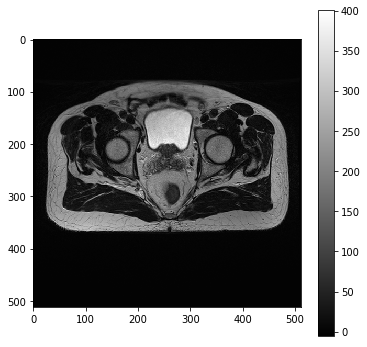

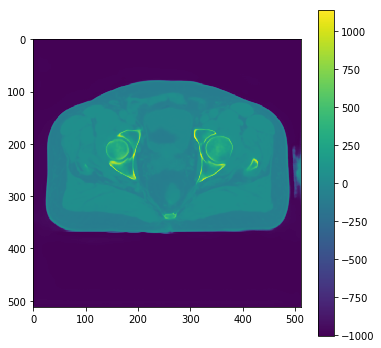

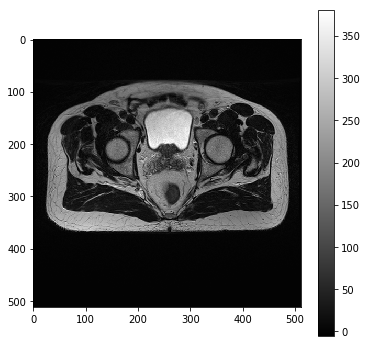

In [20]:
## using numeric scrollable label operated by the mouse wheel

window = tk.Tk()

def mouse_wheel(event):
    global Slice
    # respond to Linux or Windows wheel event
    if event.num == 5 or event.delta == -120:
        Slice -= 1
    if event.num == 4 or event.delta == 120:
        Slice += 1
    Slice_label['text'] = Slice
    #PlotMRwithLabel() # can add this and the plot will refresh when the mousewheel is activated, 
    #but it is slow to refresh and when closed it wants to plot in the jupyter script so window is slow to close

Slice = 40
MRslices = 200

window.title("Synthetic CT Generation")
window.geometry("1200x900")

ImportMR_label = Label(window, text = "location of MR dicom folder:",font=("Arial Bold", 10))
ImportMR_label.grid(column=0,row=0)

ImportMR_txt = Entry(window,width = 90)
ImportMR_txt.insert(END,'D:\\CNNdata\\SynCT_FINAL_EclipseTesting\\rawMR')
ImportMR_txt.grid(column=0,row=1)

ImportMRfiles_label = Label(window, text = "Patient ID",font=("Arial Bold", 10))
ImportMRfiles_label.grid(column=0,row=2)

ImportMRfiles_txt = Entry(window,width = 90)
ImportMRfiles_txt.insert(END,'11')
ImportMRfiles_txt.grid(column=0,row=3)


ImportAndScale_bt = Button(window, text = "Import MR", command=ImportAndZoomto512)
ImportAndScale_bt.grid(column = 0, row = 4)

Slice_label = Label(window, text = Slice, font=('courier', 18, 'bold'), width=10)
Slice_label.grid(column = 0, row = 5)

window.bind("<MouseWheel>", mouse_wheel)

PlotMR_bt = Button(window, text = "Plot MR", command=PlotMRwithLabel)
PlotMR_bt.grid(column = 0, row = 6)

# Model_Location_label = Label(window, text = "Model Location:",font=("Arial Bold", 10))
# Model_Location_label.grid(column=0,row=7)
# Model_Location_txt = Entry(window,width = 90)
# Model_Location_txt.insert(END,'D:/CNNdata/SynCT_LargerCohort/TrainedModel/')
# Model_Location_txt.grid(column=0,row=8)

# Model_Name_label = Label(window, text = "Model Name:",font=("Arial Bold", 10))
# Model_Name_label.grid(column=0,row=9)
# Model_Name_txt = Entry(window,width = 90)
# Model_Name_txt.insert(END,'24ptModel.h5')
# Model_Name_txt.grid(column=0,row=10)

PredictSynCT_bt = Button(window, text = "Predict SyntheticCT", command=clicked_PredictSynCT)
PredictSynCT_bt.grid(column=1,row=4)

PlotMRandSynCT_bt = Button(window, text = "Plot MR and SynCT", command=PlotMRandSynCTwithLabel)
PlotMRandSynCT_bt.grid(column = 1, row = 5)

SaveSynCTNumpy_bt = Button(window, text = "Save Numpy", command=SaveSynCTasNumpy)
SaveSynCTNumpy_bt.grid(column = 1, row = 8)

window.lift() # brings window to the front

window.mainloop()

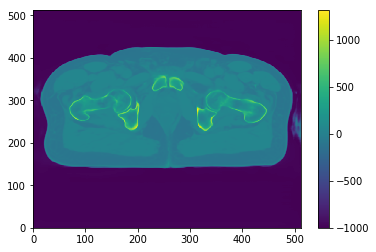

In [21]:
plt.pcolormesh(SynCTHU[30,0,:,:])
plt.colorbar()

In [22]:
MRslices = np.size(SynCTHU, 0)
MRslices

70

In [23]:
a_CT = np.zeros(len(lstFilesDCM_MR))

In [24]:
p=0
for filenameDCM in lstFilesDCM_MR:
    header = pydicom.read_file(filenameDCM)
    slicenumber = header.ImagePositionPatient[2]
    a_CT[p] = slicenumber
    p = p+1

In [25]:
a_CT

array([ 57.29773712,  51.29773712,  -8.70226288,  21.29773712,
        45.29773712,  39.29773712,  27.29773712,  33.29773712,
         3.29773712,   9.29773712,  15.29773712,  -2.70226288,
        69.29773521,  75.29773521,  87.29773521,  63.29773521,
        99.29773521, 105.29773521,  81.29773521,  93.29773545,
       117.29773521, 111.29773521, 129.29773712, 123.29773521,
       135.29773712, 141.29773712, 147.29773712, 165.29773712,
       159.29773712, 153.29773712, 177.29773712, 171.29773712,
       189.29773712, 183.29773712, 195.29773712, -11.70226288,
        -5.70226288,   0.29773712,  12.29773712,   6.29773712,
        18.29773712,  24.29773712,  54.29773712,  30.29773712,
        36.29773712,  42.29773712,  60.29773521,  48.29773712,
        66.29773521,  78.29773521,  72.29773521,  84.29773521,
        90.29773545,  96.29773521, 102.29773521, 126.29773712,
       132.29773712, 120.29773521, 114.29773521, 108.29773521,
       138.29773712, 150.29773712, 144.29773712, 156.29

In [26]:
b_CT = np.sort(a_CT,axis =-1, kind = 'quicksort', order = None)

b_CT

array([-11.70226288,  -8.70226288,  -5.70226288,  -2.70226288,
         0.29773712,   3.29773712,   6.29773712,   9.29773712,
        12.29773712,  15.29773712,  18.29773712,  21.29773712,
        24.29773712,  27.29773712,  30.29773712,  33.29773712,
        36.29773712,  39.29773712,  42.29773712,  45.29773712,
        48.29773712,  51.29773712,  54.29773712,  57.29773712,
        60.29773521,  63.29773521,  66.29773521,  69.29773521,
        72.29773521,  75.29773521,  78.29773521,  81.29773521,
        84.29773521,  87.29773521,  90.29773545,  93.29773545,
        96.29773521,  99.29773521, 102.29773521, 105.29773521,
       108.29773521, 111.29773521, 114.29773521, 117.29773521,
       120.29773521, 123.29773521, 126.29773712, 129.29773712,
       132.29773712, 135.29773712, 138.29773712, 141.29773712,
       144.29773712, 147.29773712, 150.29773712, 153.29773712,
       156.29773712, 159.29773712, 162.29773712, 165.29773712,
       168.29773712, 171.29773712, 174.29773712, 177.29

In [27]:
SynCTHUNew = np.zeros((MRslices,1,512,512), dtype = 'int')
for i in range(0,MRslices):

    SynCTHUNewRot = np.rot90(SynCTHU[i,0,:,:],2) #takes the 2D slice and rotates by 90degrees 2 times
    SynCTHUNewRotFlip = np.fliplr(SynCTHUNewRot) #takes in the 2D slice and flips LR
    SynCTHUNew[i,0,:,:] = SynCTHUNewRotFlip

In [28]:
# Get ref file
RefMR = dicom.read_file(lstFilesDCM_MR[0])
# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(RefMR.Rows), int(RefMR.Columns), len(lstFilesDCM_MR))

In [29]:
dim0 = ConstPixelDims[0]
print(dim0)
dim1 = ConstPixelDims[1]
print(dim1)

1024
1024


In [30]:

if dim0 == 512 and dim1 == 512: # checks to see if the dimensions are 512x512 (required for the model)
    SynCTSave = SynCTnumpyNew


else:      # i.e. if the dimensions of the original CT were not 512x512

    print("... converting SynCT numpy to match MR ...")

    SynCTSave = np.zeros((MRslices,1,dim0,dim1), dtype = 'int32')
    for i in range (MRslices):
        SynCTSave[i,0,:,:] = ndimage.zoom(SynCTHUNew[i,0,:,:], dim0/512, order=3)

    print("... done ...")

... converting SynCT numpy to match MR ...
... done ...


In [31]:
num1 = random.randint(0, 1000)
num1

560

In [32]:
num2 = random.randint(0, 10)
num2

5

In [33]:
SaveSynCTDCMLocation = os.path.join(PathDicomMR + '_SynCT')
os.makedirs(SaveSynCTDCMLocation)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'D:\\CNNdata\\SynCT_FINAL_EclipseTesting\\rawMR\\53_SynCT'

## Saving as DCM slices

In [34]:
for filenameDCM in lstFilesDCM_MR: #for every file in the CT DICOM location,
    header = pydicom.read_file(filenameDCM) # read the header
    sliceposition = header.ImagePositionPatient[2] # find the slice position of that file
    slicenumber = np.where(b_CT == sliceposition) # which slice in the array is this
    
    print("slicenumber = ", slicenumber[0][0])
    print("sliceposition=", sliceposition)
    if slicenumber[0][0] < MRslices:
        print("filenameDCM=", filenameDCM)
        ds = pydicom.dcmread(filenameDCM)

        for n,val in enumerate(ds.pixel_array.flat):
            #ds.pixel_array.flat[n]= SynCTnumpy1024[slicenumber[0][0],:,:].flat[n]
            ds.pixel_array.flat[n]= SynCTSave[slicenumber[0][0],0,:,:].flat[n]
        ds.PixelData = ds.pixel_array.tobytes()

    #     print(ds.SliceLocation)
    #     print(ds.RescaleIntercept)
        del ds.SmallestImagePixelValue
        del ds.LargestImagePixelValue
        ds.BitsAllocated = 16
        ds.BitsStored = 16
        ds.HighBit = 15
        ds.PixelRepresentation = 1
        ds.RescaleSlope = 1
        ds.RescaleIntercept = 0
        ds.RescaleType = 'HU'
        ds.WindowCenter = 40
        ds.WindowWidth = 400
        
        ## now trying to play with UIDs to get ensure MR and SynCT will import into Eclipse
        ## in the same series and frame of reference
        ## first is study UID which needs to be the same for all slices.
        OrigSeriesUID = ds.SeriesInstanceUID
        print(OrigSeriesUID)
        ds.SeriesInstanceUID = OrigSeriesUID + str(num1)
        print(ds.SeriesInstanceUID)
        
        ## now the Instance UID which will be different and unique for each slice
        OrigInstanceUID = ds.SOPInstanceUID
        print(OrigInstanceUID)

        print(ds.SOPInstanceUID)
        ds.SOPInstanceUID = ds.SOPInstanceUID[:-2]
        ds.SOPInstanceUID = ds.SOPInstanceUID + str(num2) + str(slicenumber[0][0]) ##using num1 makes UID too long
        print(ds.SOPInstanceUID)
        
        print("SOPclassUID = ", ds[0x08,0x16].value)
        ds[0x08,0x16].value = '1.2.840.10008.5.1.4.1.1.2'
        print("SOPclassUID new = ", ds[0x08,0x16].value)
        
    #     print(ds.RescaleIntercept)
        ds.Modality = 'CT'
        
        print("tilt = ", ds.ImageOrientationPatient)
        orig = ds.ImageOrientationPatient
        rounded = np.round(orig)
        ds.ImageOrientationPatient[0]=str(rounded[0])
        ds.ImageOrientationPatient[1]=str(rounded[1])
        ds.ImageOrientationPatient[2]=str(rounded[2])
        ds.ImageOrientationPatient[3]=str(rounded[3])
        ds.ImageOrientationPatient[4]=str(rounded[4])
        ds.ImageOrientationPatient[5]=str(rounded[5])
        print("new tilt = ", ds.ImageOrientationPatient)
        
        target = os.path.join(str(SaveSynCTDCMLocation) + '\SynCT' + str(slicenumber[0][0]) + '.dcm')

        ds.save_as(target)
    else:
        pass

slicenumber =  23
sliceposition= 57.297737121582
filenameDCM= D:\CNNdata\SynCT_FINAL_EclipseTesting\rawMR\53\2.16.840.1.114362.1.11826050.21972341699.557275565.105.2795.dcm
2.16.840.1.114362.1.11826050.21972341699.557275565.1082.2794
2.16.840.1.114362.1.11826050.21972341699.557275565.1082.2794560
2.16.840.1.114362.1.11826050.21972341699.557275565.105.2795
2.16.840.1.114362.1.11826050.21972341699.557275565.105.2795
2.16.840.1.114362.1.11826050.21972341699.557275565.105.27523
SOPclassUID =  1.2.840.10008.5.1.4.1.1.4
SOPclassUID new =  1.2.840.10008.5.1.4.1.1.2
tilt =  ['0.99998629224883', '0.00523596356406', '0', '-0.0052359635641', '0.99998629224883', '0']
new tilt =  ['1.0', '0.0', '0.0', '-0.0', '1.0', '0.0']
slicenumber =  21
sliceposition= 51.297737121582
filenameDCM= D:\CNNdata\SynCT_FINAL_EclipseTesting\rawMR\53\2.16.840.1.114362.1.11826050.21972341699.557275565.1082.2793.dcm
2.16.840.1.114362.1.11826050.21972341699.557275565.1082.2794
2.16.840.1.114362.1.11826050.21972341699.5572

2.16.840.1.114362.1.11826050.21972341699.557275565.1082.2794
2.16.840.1.114362.1.11826050.21972341699.557275565.1082.2794560
2.16.840.1.114362.1.11826050.21972341699.557275565.346.2806
2.16.840.1.114362.1.11826050.21972341699.557275565.346.2806
2.16.840.1.114362.1.11826050.21972341699.557275565.346.28527
SOPclassUID =  1.2.840.10008.5.1.4.1.1.4
SOPclassUID new =  1.2.840.10008.5.1.4.1.1.2
tilt =  ['0.99998629224883', '0.00523596356406', '0', '-0.0052359635641', '0.99998629224883', '0']
new tilt =  ['1.0', '0.0', '0.0', '-0.0', '1.0', '0.0']
slicenumber =  29
sliceposition= 75.297735214233
filenameDCM= D:\CNNdata\SynCT_FINAL_EclipseTesting\rawMR\53\2.16.840.1.114362.1.11826050.21972341699.557275565.368.2807.dcm
2.16.840.1.114362.1.11826050.21972341699.557275565.1082.2794
2.16.840.1.114362.1.11826050.21972341699.557275565.1082.2794560
2.16.840.1.114362.1.11826050.21972341699.557275565.368.2807
2.16.840.1.114362.1.11826050.21972341699.557275565.368.2807
2.16.840.1.114362.1.11826050.219723

2.16.840.1.114362.1.11826050.21972341699.557275565.1082.2794
2.16.840.1.114362.1.11826050.21972341699.557275565.1082.2794560
2.16.840.1.114362.1.11826050.21972341699.557275565.619.2818
2.16.840.1.114362.1.11826050.21972341699.557275565.619.2818
2.16.840.1.114362.1.11826050.21972341699.557275565.619.28549
SOPclassUID =  1.2.840.10008.5.1.4.1.1.4
SOPclassUID new =  1.2.840.10008.5.1.4.1.1.2
tilt =  ['0.99998629224883', '0.00523596356406', '0', '-0.0052359635641', '0.99998629224883', '0']
new tilt =  ['1.0', '0.0', '0.0', '-0.0', '1.0', '0.0']
slicenumber =  51
sliceposition= 141.29773712158
filenameDCM= D:\CNNdata\SynCT_FINAL_EclipseTesting\rawMR\53\2.16.840.1.114362.1.11826050.21972341699.557275565.644.2819.dcm
2.16.840.1.114362.1.11826050.21972341699.557275565.1082.2794
2.16.840.1.114362.1.11826050.21972341699.557275565.1082.2794560
2.16.840.1.114362.1.11826050.21972341699.557275565.644.2819
2.16.840.1.114362.1.11826050.21972341699.557275565.644.2819
2.16.840.1.114362.1.11826050.219723

2.16.840.1.114362.1.11826050.21972341699.557275565.1082.2794
2.16.840.1.114362.1.11826050.21972341699.557275565.1082.2794560
2.16.840.1.114362.1.11826050.21972341699.557275565.897.2830
2.16.840.1.114362.1.11826050.21972341699.557275565.897.2830
2.16.840.1.114362.1.11826050.21972341699.557275565.897.2852
SOPclassUID =  1.2.840.10008.5.1.4.1.1.4
SOPclassUID new =  1.2.840.10008.5.1.4.1.1.2
tilt =  ['0.99998629224883', '0.00523596356406', '0', '-0.0052359635641', '0.99998629224883', '0']
new tilt =  ['1.0', '0.0', '0.0', '-0.0', '1.0', '0.0']
slicenumber =  4
sliceposition= 0.29773712158203
filenameDCM= D:\CNNdata\SynCT_FINAL_EclipseTesting\rawMR\53\2.16.840.1.114362.1.11826050.21972341699.557275565.921.2831.dcm
2.16.840.1.114362.1.11826050.21972341699.557275565.1082.2794
2.16.840.1.114362.1.11826050.21972341699.557275565.1082.2794560
2.16.840.1.114362.1.11826050.21972341699.557275565.921.2831
2.16.840.1.114362.1.11826050.21972341699.557275565.921.2831
2.16.840.1.114362.1.11826050.2197234

2.16.840.1.114362.1.11826050.21972341699.557275565.1082.2794
2.16.840.1.114362.1.11826050.21972341699.557275565.1082.2794560
2.16.840.1.114362.1.11826050.21972341699.557275566.171.2842
2.16.840.1.114362.1.11826050.21972341699.557275566.171.2842
2.16.840.1.114362.1.11826050.21972341699.557275566.171.28526
SOPclassUID =  1.2.840.10008.5.1.4.1.1.4
SOPclassUID new =  1.2.840.10008.5.1.4.1.1.2
tilt =  ['0.99998629224883', '0.00523596356406', '0', '-0.0052359635641', '0.99998629224883', '0']
new tilt =  ['1.0', '0.0', '0.0', '-0.0', '1.0', '0.0']
slicenumber =  30
sliceposition= 78.297735214233
filenameDCM= D:\CNNdata\SynCT_FINAL_EclipseTesting\rawMR\53\2.16.840.1.114362.1.11826050.21972341699.557275566.194.2843.dcm
2.16.840.1.114362.1.11826050.21972341699.557275565.1082.2794
2.16.840.1.114362.1.11826050.21972341699.557275565.1082.2794560
2.16.840.1.114362.1.11826050.21972341699.557275566.194.2843
2.16.840.1.114362.1.11826050.21972341699.557275566.194.2843
2.16.840.1.114362.1.11826050.219723

2.16.840.1.114362.1.11826050.21972341699.557275565.1082.2794
2.16.840.1.114362.1.11826050.21972341699.557275565.1082.2794560
2.16.840.1.114362.1.11826050.21972341699.557275566.491.2854
2.16.840.1.114362.1.11826050.21972341699.557275566.491.2854
2.16.840.1.114362.1.11826050.21972341699.557275566.491.28550
SOPclassUID =  1.2.840.10008.5.1.4.1.1.4
SOPclassUID new =  1.2.840.10008.5.1.4.1.1.2
tilt =  ['0.99998629224883', '0.00523596356406', '0', '-0.0052359635641', '0.99998629224883', '0']
new tilt =  ['1.0', '0.0', '0.0', '-0.0', '1.0', '0.0']
slicenumber =  54
sliceposition= 150.29773712158
filenameDCM= D:\CNNdata\SynCT_FINAL_EclipseTesting\rawMR\53\2.16.840.1.114362.1.11826050.21972341699.557275566.514.2855.dcm
2.16.840.1.114362.1.11826050.21972341699.557275565.1082.2794
2.16.840.1.114362.1.11826050.21972341699.557275565.1082.2794560
2.16.840.1.114362.1.11826050.21972341699.557275566.514.2855
2.16.840.1.114362.1.11826050.21972341699.557275566.514.2855
2.16.840.1.114362.1.11826050.219723

In [35]:
print(ds)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'NORM', 'DIS2D']
(0008, 0012) Instance Creation Date              DA: '20200309'
(0008, 0013) Instance Creation Time              TM: '132451.241000'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 2.16.840.1.114362.1.11826050.21972341699.557275566.703.28568
(0008, 0020) Study Date                          DA: '20200309'
(0008, 0021) Series Date                         DA: '20200309'
(0008, 0022) Acquisition Date                    DA: '20200309'
(0008, 0023) Content Date                        DA: '20200309'
(0008, 0030) Study Time                          TM: '130731'
(0008, 0031) Series Time                         TM: '132428.991000'
(0008, 0032) Acquisition Time                    TM: '131751.797500'
(0008, 0033) Content Time                        TM: '132451.2

In [ ]:

## Used for testing dicom save options:

# for filenameDCM in lstFilesDCM_MR: #for every file in the CT DICOM location,
#     header = pydicom.read_file(filenameDCM) # read the header
#     sliceposition = header.ImagePositionPatient[2] # find the slice position of that file
#     slicenumber = np.where(b_CT == sliceposition) # which slice in the array is this
    
#     print("slicenumber = ", slicenumber[0][0])
#     print("sliceposition=", sliceposition)
#     if slicenumber[0][0] < MRslices:
#         print("filenameDCM=", filenameDCM)
#         ds = pydicom.dcmread(filenameDCM)
#         print(ds.SOPInstanceUID)
#         ds.SOPInstanceUID = ds.SOPInstanceUID[:-2]
#         print(ds.SOPInstanceUID)
#         ds.SOPInstanceUID = ds.SOPInstanceUID + str(num2) + str(slicenumber[0][0])
#         #=replace
#         print(ds.SOPInstanceUID)